In [5]:
import jax
from jax import grad, jit, lax, random, vmap
from jax.experimental.ode import odeint
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

In [11]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
PRES_PATH = "../../Grad_School/VariousPresentations/lab_meeting_04_18_23/figures/"

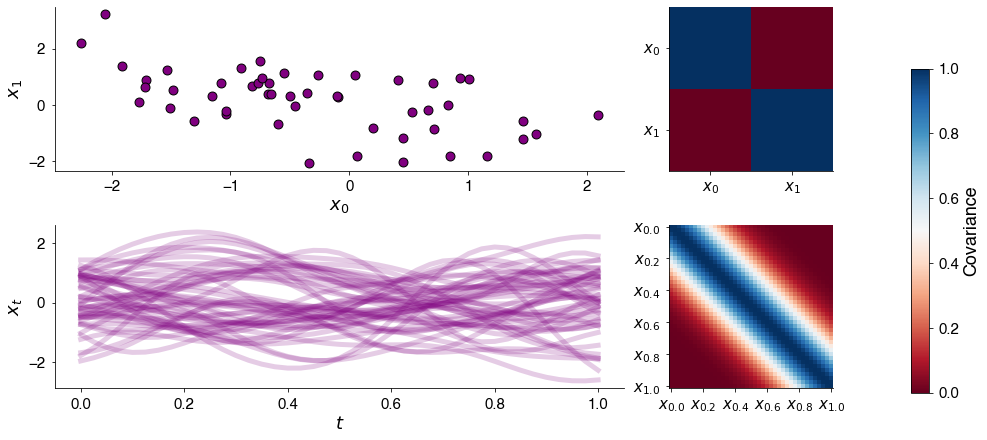

In [38]:
# Multivariate Gaussian
# Sampling nD from Gaussian process w/ covariance matrix as heatplot
from scipy.stats import multivariate_normal

fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.0, 0.4])
ax_2d_scatter = fig.add_subplot(spec[0])

# Our 2-dimensional distribution will be over variables X and Y
N = 50

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1]])


# The distribution on the variables X, Y packed into pos.
F = multivariate_normal(mu, Sigma)
Z = F.rvs(N)

ax_2d_scatter.scatter(Z[:,0], Z[:,1], ec="k", s=80, color="purple")
ax_2d_scatter.set_xlabel(r"$x_{0}$")
ax_2d_scatter.set_ylabel(r"$x_{1}$")

ax_2d_corr = fig.add_subplot(spec[1])
im=ax_2d_corr.imshow(Sigma, cmap='RdBu', vmin=0, vmax=1)
cbar_ax = fig.add_axes([1.05, 0.1, 0.02, 0.75])
fig.colorbar(im, cbar_ax, label="Covariance")
#ax_2d_corr.set_title(r"Covariance matrix")
ax_2d_corr.set_xticks([0, 1])
ax_2d_corr.set_yticks([0,1])
ax_2d_corr.set_xticklabels([r"$x_{0}$", r"$x_{1}$"])
ax_2d_corr.set_yticklabels([r"$x_{0}$", r"$x_{1}$"])

# Repeat for Gaussian Process
def SE_kernel(x, alpha, rho):
    return np.exp(- np.square(x - x[:, None]) / (2 * rho**2))
 
# Sample N GPs
ts = np.linspace(0, 1, 41)

Sigma = SE_kernel(ts, alpha=1.0, rho=0.2)
Z_gp = multivariate_normal(np.zeros_like(ts), Sigma, allow_singular=True).rvs(N)

ax_nd_plot = fig.add_subplot(spec[2])
ax_nd_plot.plot(ts, Z_gp.T, color="purple", alpha=0.2)

ax_nd_plot.set_ylabel(r"$x_{t}$")
ax_nd_plot.set_xlabel(r"$t$")

ax_nd_corr = fig.add_subplot(spec[3])

im=ax_nd_corr.imshow(Sigma, cmap='RdBu', vmin=0, vmax=1)
#ax_nd_corr.set_title(r"Covariance matrix")

ticks = [*range(len(ts))][::8]
label_nums = [f"{t: .1f}" for t in ts[::8]]
labels = [r"$x_{" + lb + "}$"  for lb in label_nums]

ax_nd_corr.set_xticks(ticks)
ax_nd_corr.set_yticks(ticks)
ax_nd_corr.set_xticklabels(labels)
ax_nd_corr.set_yticklabels(labels)


fig_gp = fig
fig_gp.savefig(PRES_PATH + "gp_intro.svg", bbox_inches='tight')

In [13]:
# Getting base parameters
R0 = 2.8
gamma = 1 / 3.2
beta = R0 * gamma

Text(0.5, 0, 'Proportion vaccinated')

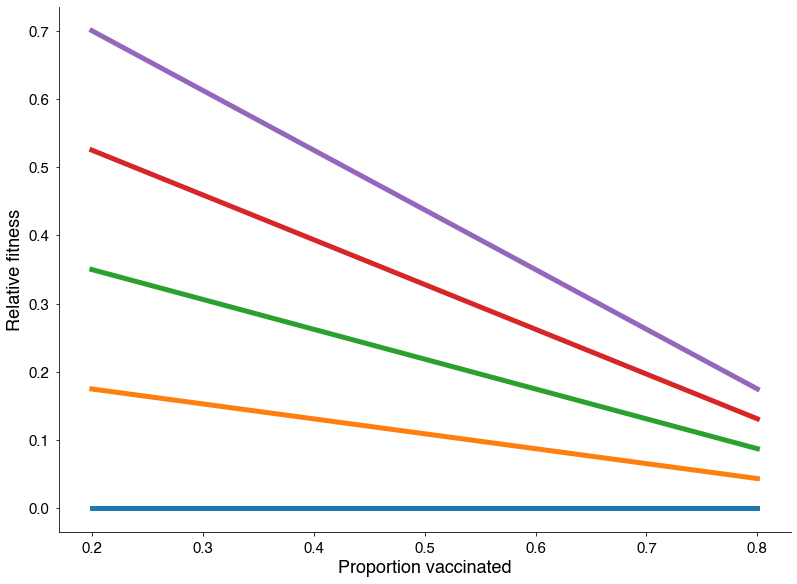

In [14]:
# Growth advantage in absence of immune escape for pure transmissibility

## Relative fitness correlates with relative fitness in the absence of immune escape


# A. Plot Relative fitness as a function of eta_T for various proportion vaccinated


fig = plt.figure(figsize=(12., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.0, 0.1])
ax = fig.add_subplot(spec[0])

prop_exposed = np.linspace(0.2,0.8,5)

eta_T = np.linspace(1.0, 2.0, 5)
var_t_lambda = (eta_T - 1) * beta * (1 - prop_exposed)[:,None]


ax.plot(prop_exposed, var_t_lambda)
ax.set_xlabel("Transmissibility increase")
ax.set_ylabel("Relative fitness")
ax.set_xlabel("Proportion vaccinated")




In [15]:
# Showing relative fitness for proportion vaccinated


# A. Proportion vaccinated on x-axis
# We have fixed transmissibility increase and escape fraction 
# Want to mark point at which transmissibility is preferred

# B. Point of vaccination where escape preferred various eta_E and eta_T

In [21]:
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Transmissibility variant", "Escape variant"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}


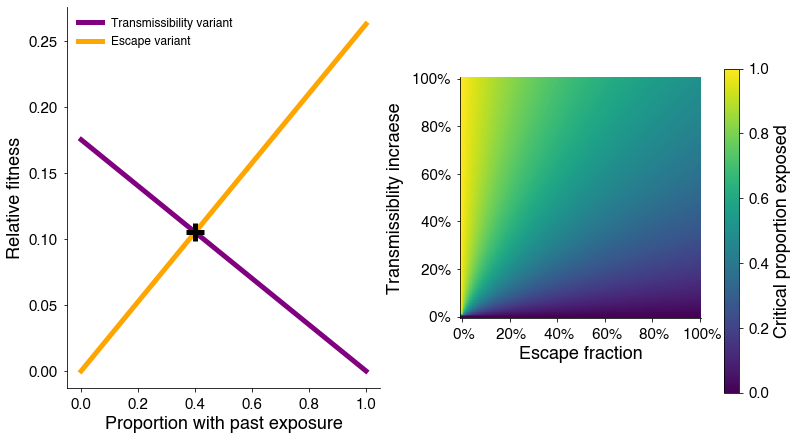

In [37]:
# Getting base parameters
eta_E = 0.3
eta_T = 1.2

prop_exposed = np.linspace(0,1,31)

# Plot

fig = plt.figure(figsize=(10., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.3, 1.0])
ax = fig.add_subplot(spec[0])

# 
var_t_lambda = (eta_T - 1) * beta * (1 - prop_exposed)
var_e_lambda = eta_E * beta * prop_exposed
ax.plot(prop_exposed, var_t_lambda, color = VART_COLOR, label = VART_LABEL)
ax.plot(prop_exposed, var_e_lambda, color = VARE_COLOR, label = VARE_LABEL)
ax.legend(frameon=False)
ax.set_xlabel("Proportion with past exposure")
ax.set_ylabel("Relative fitness")

# Highlight point of intersection
def critical_proportion(eta_T, eta_E):
    return (eta_T - 1) / (eta_E+ eta_T-1)

crit_prop = critical_proportion(eta_T, eta_E)
crit_relfit = eta_E * beta * crit_prop
ax.scatter(crit_prop, crit_relfit , s=300, color="k", marker="+", zorder=3)

ax = fig.add_subplot(spec[1])

eta_T = np.linspace(2.00, 1.0, 81)
eta_E = np.linspace(0.001, 0.996, 81)

eta_Emg, eta_Tmg = np.meshgrid(eta_E, eta_T)

crit_props = critical_proportion(eta_Tmg, eta_Emg)

im=ax.imshow(crit_props, vmin=0, vmax=1)
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.75])
fig.colorbar(im, cbar_ax, label = "Critical proportion exposed")
yticks = [*range(len(eta_T))][::16]
xticks = [*range(len(eta_E))][::16]

ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xticklabels([f"{eta_E[v]: .2f}" for v in xticks])
ax.set_yticklabels([f"{eta_T[v]: .2f}" for v in yticks])

ax.set_xticklabels([f"{eta_E[v]: .0%}" for v in xticks])
ax.set_yticklabels([f"{(eta_T[v] -1): .0%}" for v in yticks])

ax.set_ylabel("Transmissiblity incraese")
ax.set_xlabel("Escape fraction")

#TODO: Note this threshold is independent of R0 (it only effects the height of the relative fitness)

fig_te_tradeoff = fig

fig_te_tradeoff.savefig(PRES_PATH + "transmission_tradeoff.svg", bbox_inches='tight')

In [188]:
crit_props

array([[-9.08181818e+02, -4.55427866e+01, -2.28826941e+01, ...,
        -4.25043983e-02, -2.08099421e-02,  0.00000000e+00],
       [-4.64518884e+01, -2.33593141e+01, -1.53853464e+01, ...,
        -4.16191040e-02, -2.03853421e-02,  0.00000000e+00],
       [-2.38355164e+01, -1.57080617e+01, -1.15884690e+01, ...,
        -4.07699355e-02, -1.99777225e-02,  0.00000000e+00],
       ...,
       [-1.04042152e+00, -9.97997844e-01, -9.57302354e-01, ...,
        -2.12548217e-02, -1.05156566e-02,  0.00000000e+00],
       [-1.01877038e+00, -9.77652549e-01, -9.38176238e-01, ...,
        -2.10311140e-02, -1.04061308e-02,  0.00000000e+00],
       [-9.98001998e-01, -9.58120205e-01, -9.19799401e-01, ...,
        -2.08120664e-02, -1.02988629e-02,  0.00000000e+00]])

In [190]:
eta_E

array([0.001     , 0.02138776, 0.04177551, 0.06216327, 0.08255102,
       0.10293878, 0.12332653, 0.14371429, 0.16410204, 0.1844898 ,
       0.20487755, 0.22526531, 0.24565306, 0.26604082, 0.28642857,
       0.30681633, 0.32720408, 0.34759184, 0.36797959, 0.38836735,
       0.4087551 , 0.42914286, 0.44953061, 0.46991837, 0.49030612,
       0.51069388, 0.53108163, 0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ])

In [191]:
eta_T

array([1.01      , 1.03020408, 1.05040816, 1.07061224, 1.09081633,
       1.11102041, 1.13122449, 1.15142857, 1.17163265, 1.19183673,
       1.21204082, 1.2322449 , 1.25244898, 1.27265306, 1.29285714,
       1.31306122, 1.33326531, 1.35346939, 1.37367347, 1.39387755,
       1.41408163, 1.43428571, 1.4544898 , 1.47469388, 1.49489796,
       1.51510204, 1.53530612, 1.5555102 , 1.57571429, 1.59591837,
       1.61612245, 1.63632653, 1.65653061, 1.67673469, 1.69693878,
       1.71714286, 1.73734694, 1.75755102, 1.7777551 , 1.79795918,
       1.81816327, 1.83836735, 1.85857143, 1.87877551, 1.89897959,
       1.91918367, 1.93938776, 1.95959184, 1.97979592, 2.        ])